In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore')

path = Path(os.getcwd()).parent


def bootstrap(n):
    
    bootstrap = n*[0]
    for _ in range(n):
        bootstrap[np.random.randint(n)] = 1
    
    return bootstrap

def sample(softmax, temperature):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)

    return probas[0]

def remove(preds, max_drop, temperature):
    
    to_drop = len(preds)*[0]
    for _ in range(max_drop):
        to_drop += (sample(preds, temperature))
        
    return to_drop

def plots(score, temperature):
    
    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, p) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]

    plt.plot(auc)
    plt.plot(len(auc)*[0.5])
    plt.xlabel("number of iterations")
    plt.ylabel('auc')
    plt.grid()
    plt.title(temperature)
    plt.show()
    
    plt.plot([k[0] for k in ks])
    plt.ylabel('ks-stats')
    plt.xlabel('number of iterations')
    plt.grid()
    plt.show()
    
    plt.plot([k[1] for k in ks], linewidth=2.0)
    plt.ylabel('p-value')
    plt.xlabel('number of iterations')
    plt.grid()
    plt.show()


## Attribute Comparison

Each row is labelled with its (survey) *source*.

- *Source*
- Geschlecht
- Alter
- Schulabschluss 
- Berufsgruppe
- Erwerbstätigkeit
- wöchentliche Arbeitszeit
- Berufsgruppe 
- BRS1, BRS2, BRS3, BRS4, BRS5, BRS6
- Optimismus
- Pessimismus 
- ASKU1, ASKU2, ASKU3
- IE_int1
- IE_int2 
- IE_ext1
- IE_ext2

### Preprocessing: Allensbach

In [2]:
allensbach_cols = ['S01', 'S02', 'S03_rec', 'S04_rec', 'S05',
                   'V04_01', 'V04_02', 'V04_03', 'V04_04', 'V04_05', 'V04_06',
                   'S06b_rec', 'V01', 'V22',
                   'V20_5', 'V20_6', 'V20_7',
                   'V20_1', 'V20_2', 'V20_3', 'V20_4']

'''
nicht in ALLENSBACH:
EINW
Frage 17-19 FB_Neuroenhancement
----------------------------------------------

LO01_01

soziale unterstützung nicht in gbs (OS02-OS04)

ASKU ist in Allensbach 3 Fragen. jeweils 5 antworten.
GBS hat ASKU einmalig 10 Antowrten.	

Berugsgruppe zweimal. Zuordnung ändern.

Wohnortgröße fehlt in GBS.

dm20 und dm42 und dm53 nicht in GBS.

di5 = {'sehr viel Anteilnahme und Interesse':5, 
       'viel Anteilnahme und Interesse': 4, 
       'weder viel noch wenig': 3, 
       'wenig Anteilnahme und Interesse': 2, 
       'keine Anteilnahme und Interesse': 1,
       'keine Angabe':3}
gbs.replace({'Soziale Unterstuetzung': di5}, inplace=True)
'''

names = ['Geschlecht', 'Alter', 'Schulabschluss', 'Berufsgruppe', 'Erwerbstätigkeit',
         'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6',
         'woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus',
         'ASKU1', 'ASKU2', 'ASKU3',
         'IE_int1', 'IE_int2', 'IE_ext1', 'IE_ext2']

allensbach = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                         usecols = allensbach_cols,
                         delimiter=';', low_memory=False)

allensbach.replace(',', '.', regex=True, inplace=True)
allensbach.replace(' ', np.nan, regex=True, inplace=True)

allensbach.rename(columns= dict(zip(allensbach_cols, names)), inplace=True)

allensbach.head()

,Geschlecht,Alter,Erwerbstätigkeit,Optimismus,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,...,IE_int2,IE_ext1,IE_ext2,ASKU1,ASKU2,ASKU3,Pessimismus,Schulabschluss,Berufsgruppe,woechentlicheArbeitszeit
0,2,73,2,7,5,4,1,4,4,5,...,1,5,4,1,1,1,1,2,8,NaN
1,2,24,NaN,5,2,4,2,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,51,1,2,2,4,NaN,5,1,5,...,2,NaN,4,2,2,3,6,3,3,4
3,1,57,1,6,5,3,5,3,5,3,...,2,4,5,1,2,1,2,5,2,3
4,1,64,2,4,4,4,4,4,4,4,...,3,2,2,5,1,1,4,2,1,NaN


### Preprocessing: GBS

In [3]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

# Rename 'GBS-CODE' column
key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

# Merge GBS "Umfrage Wellen" and create dataframe
gbs = pd.merge(gbs1, gbs2, how='inner', on=key)
gbs = pd.merge(gbs, mapping1, how='left', on=key)
gbs = pd.merge(gbs, mapping2, how='left', on=key)

gbs_cols = ['am01', 'am02_02', 'am14', 'am22', 'am17',
           'br01_01', 'br01_02', 'br01_03', 'br01_04', 'br01_05', 'br01_06',
           'am20_01', 'so01_01', 'so02_01',
           'sw02_01', 'sw02_02', 'sw02_03',
           'ie01_01', 'ie01_02', 'ie01_03', 'ie01_04']+[key]

gbs = gbs[gbs_cols]
gbs.rename(columns= dict(zip(gbs_cols, names+['Id'])), inplace=True)

del mapping1, mapping2, gbs1, gbs2

gbs.sort_values('Id', ascending=1, inplace=True)

twice = []
for i in range(len(gbs.Id)-1):
    if gbs.iloc[[i]].values[0][-1] == gbs.iloc[[i+1]].values[0][-1]:
        print(gbs.iloc[[i]].values[0][-1], gbs.iloc[[i+1]].values[0][-1])
        twice.append(gbs.iloc[[i]].index)
gbs = gbs[~gbs['Id'].isin(twice)]
        
gbs = gbs.iloc[::2, :]

GBS+00027 GBS+00027
GBS+00032 GBS+00032
GBS+00071 GBS+00071
GBS+00084 GBS+00084
GBS+00092 GBS+00092
GBS+00123 GBS+00123
GBS+00135 GBS+00135
GBS+00143 GBS+00143
GBS+00172 GBS+00172
GBS+00179 GBS+00179
GBS+00180 GBS+00180
GBS+00183 GBS+00183
GBS+00199 GBS+00199
GBS+00226 GBS+00226
GBS+00232 GBS+00232
GBS+00234 GBS+00234
GBS+00242 GBS+00242
GBS+00253 GBS+00253
GBS+00271 GBS+00271
GBS+00272 GBS+00272
GBS-01709 GBS-01709
GBS-01759 GBS-01759
GBS-01820 GBS-01820
GBS-02103 GBS-02103
GBS-02826 GBS-02826
GBS-03597 GBS-03597
GBS-03772 GBS-03772
GBS-03802 GBS-03802
GBS-04010 GBS-04010
GBS-04352 GBS-04352
GBS-04558 GBS-04558
GBS-04614 GBS-04614
GBS-04771 GBS-04771
GBS-05132 GBS-05132
GBS-05278 GBS-05278
GBS-05283 GBS-05283
GBS-05426 GBS-05426
GBS-05717 GBS-05717
GBS-05758 GBS-05758
GBS-05832 GBS-05832
GBS-06055 GBS-06055
GBS-06611 GBS-06611
GBS-06786 GBS-06786
GBS-06972 GBS-06972
GBS-06978 GBS-06978
GBS-07018 GBS-07018
GBS-07026 GBS-07026
GBS-07100 GBS-07100
GBS-07239 GBS-07239
GBS-07345 GBS-07345


GBS-34759 GBS-34759
GBS-34866 GBS-34866
GBS-34889 GBS-34889
GBS-34971 GBS-34971
GBS-35137 GBS-35137
GBS-35139 GBS-35139
GBS-35230 GBS-35230
GBS-35255 GBS-35255
GBS-35393 GBS-35393
GBS-35800 GBS-35800
GBS-35839 GBS-35839
GBS-35943 GBS-35943
GBS-35948 GBS-35948
GBS-35965 GBS-35965
GBS-36088 GBS-36088


### VALUE MAPPING

In [4]:
di1 = {'männlich': 1, "Männlich": 1, 'weiblich': 2, "Weiblich": 2, '[NA] Keine Angabe':np.nan}
gbs.replace({"Geschlecht": di1}, inplace=True)

di2 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}
gbs.replace({'Schulabschluss': di2}, inplace=True)

di3 = {
    'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':8,
    'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':5,
    'Angestellte(r)':3,
    'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':4,
    'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':2,
    '[NA] Keine Angabe':8,
    'keine passende Angabe':8,
    'Ausbildung':8,
    'Arbeiter/-in':3,
    'mithelfende(r) Familienangehörige(r)':1
}
gbs.replace({'Berufsgruppe':di3}, inplace=True)

arbeitszeit = []
for w in gbs.woechentlicheArbeitszeit:
    if w < 20:
        arbeitszeit.append(1)
    elif w >= 20 and w < 30:
        arbeitszeit.append(2)
    elif w >= 30 and w <= 40:
        arbeitszeit.append(3)
    elif w > 40 and w < 50:
        arbeitszeit.append(4)
    else:
        arbeitszeit.append(5)
gbs['woechentlicheArbeitszeit'] = arbeitszeit

di4 = {9:2,
       999:2,
      -3:2,
      -1:2,
      3:2}
allensbach.replace({'Erwerbstätigkeit': di4}, inplace=True)
gbs.replace({'Erwerbstätigkeit':di4}, inplace=True)

gbs.head()

,Geschlecht,Alter,Schulabschluss,Berufsgruppe,Erwerbstätigkeit,BRS1,BRS2,BRS3,BRS4,BRS5,...,Optimismus,Pessimismus,ASKU1,ASKU2,ASKU3,IE_int1,IE_int2,IE_ext1,IE_ext2,Id
454,1.0,48.0,3.0,4.0,1.0,3.0,2.0,3.0,3.0,3.0,...,3.0,4.0,3.0,3.0,2.0,3.0,3.0,4.0,4.0,GBS+00027
440,2.0,68.0,5.0,8.0,1.0,5.0,1.0,5.0,1.0,5.0,...,7.0,1.0,4.0,4.0,4.0,5.0,5.0,2.0,1.0,GBS+00032
751,2.0,56.0,3.0,4.0,1.0,4.0,4.0,2.0,4.0,2.0,...,4.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,GBS+00071
910,2.0,55.0,4.0,3.0,1.0,4.0,2.0,4.0,3.0,4.0,...,5.0,2.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,GBS+00084
307,2.0,60.0,5.0,NaN,NaN,5.0,2.0,5.0,2.0,5.0,...,6.0,2.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,GBS+00092


In [5]:
allensbach = allensbach.fillna(allensbach.median())
gbs = gbs.fillna(gbs.median())

#for i in names:
#    print(gbs[i].value_counts()) 
#    print(allensbach[i].value_counts())
#    print('#####################')

gbs['label'] = 1
allensbach['label'] = 0

data = pd.concat([gbs, allensbach], sort=True).copy(deep=True)

drop = ['ASKU1', 'ASKU2', 'ASKU3']
data.drop(columns=drop, axis=1, inplace=True)

cols = list(data.columns) 
meta = ['label', 'Id', 'bootstrap']
for m in meta:
    if m in cols:
        cols.remove(m)

data.head()

,Alter,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,Berufsgruppe,Erwerbstätigkeit,Geschlecht,IE_ext1,IE_ext2,IE_int1,IE_int2,Id,Optimismus,Pessimismus,Schulabschluss,label,woechentlicheArbeitszeit
454,48,3,2,3,3,3,4,4,1,1.0,4,4,3,3,GBS+00027,3,4,3,1,4
440,68,5,1,5,1,5,1,8,1,2.0,2,1,5,5,GBS+00032,7,1,5,1,1
751,56,4,4,2,4,2,4,4,1,2.0,3,3,3,3,GBS+00071,4,4,3,1,3
910,55,4,2,4,3,4,2,3,1,2.0,2,2,4,4,GBS+00084,5,2,4,1,3
307,60,5,2,5,2,5,2,3,1,2.0,2,2,4,4,GBS+00092,6,2,5,1,5


In [6]:
data_base = data.copy(deep=True)

###################################


c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


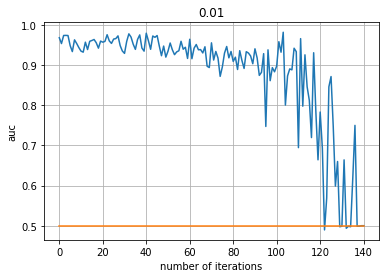

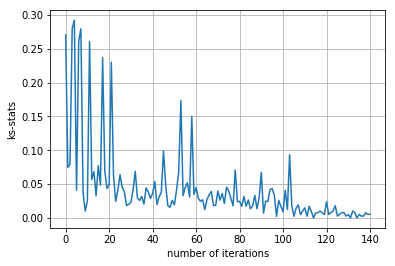

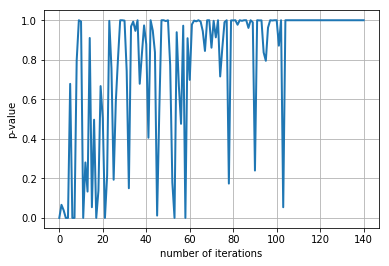

###################################


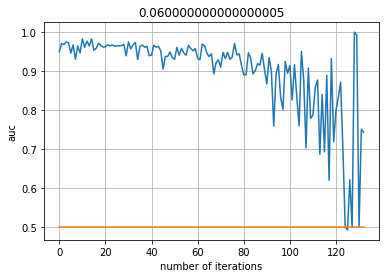

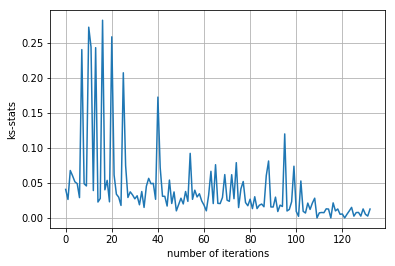

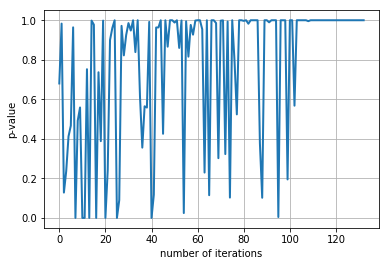

###################################


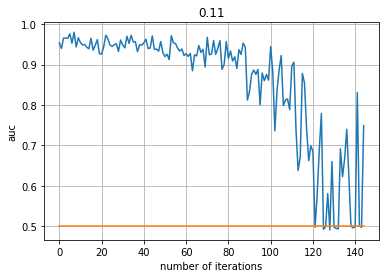

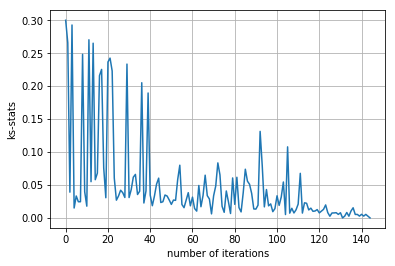

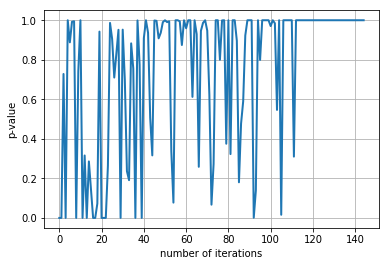

###################################


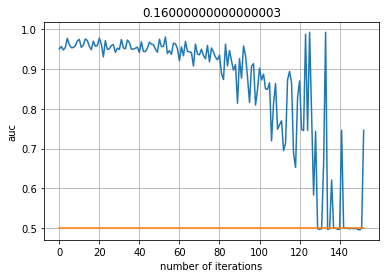

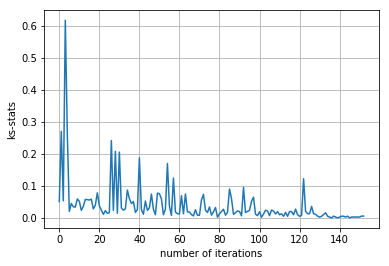

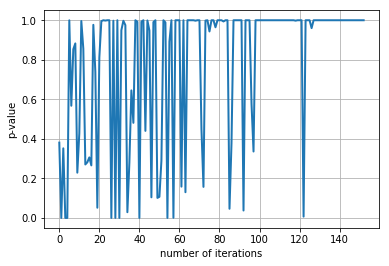

###################################


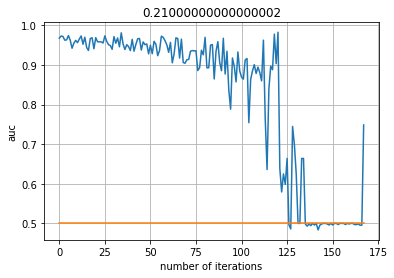

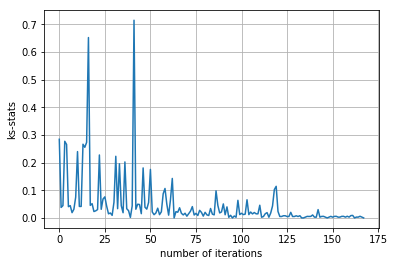

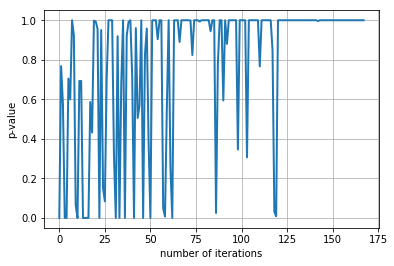

###################################


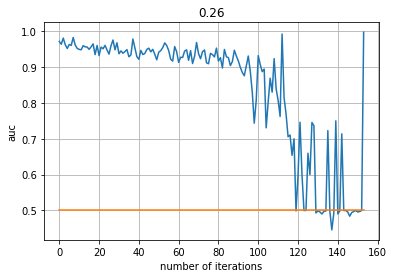

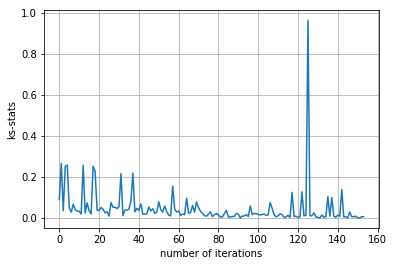

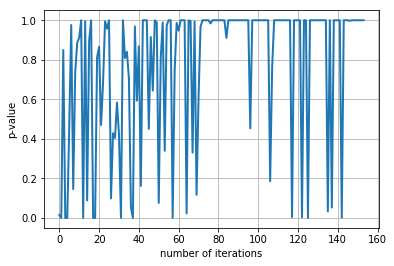

###################################


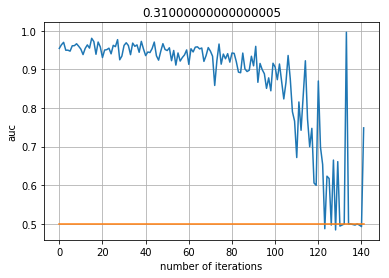

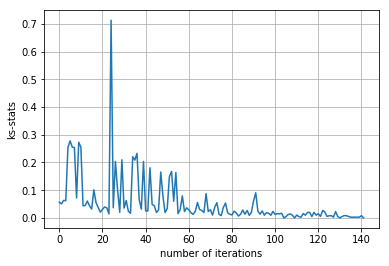

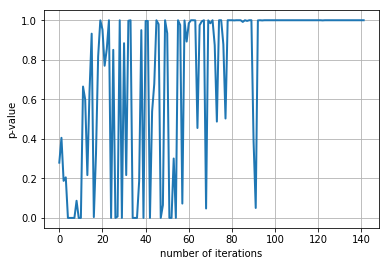

###################################


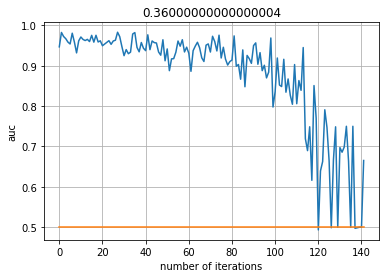

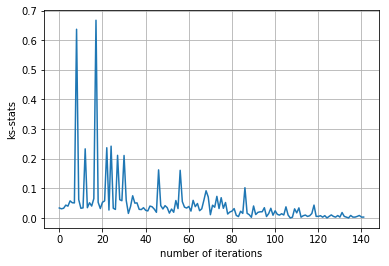

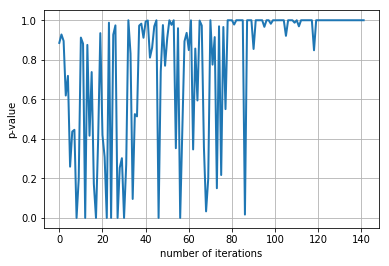

###################################


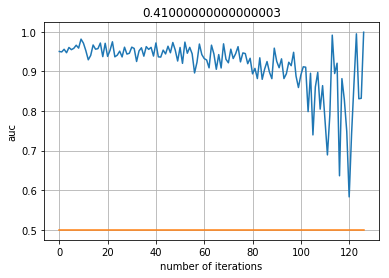

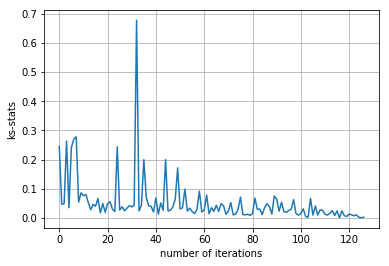

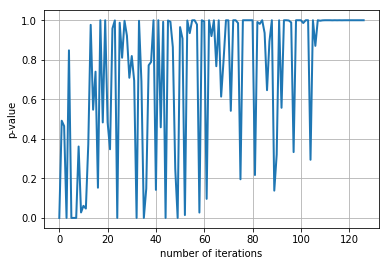

###################################


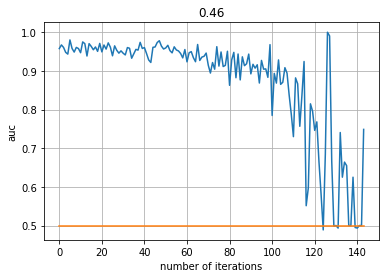

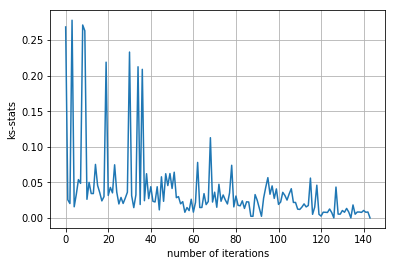

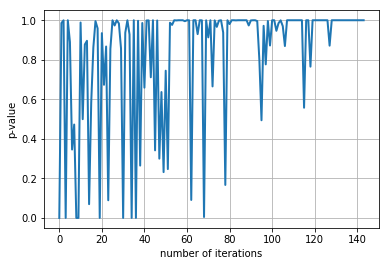

###################################


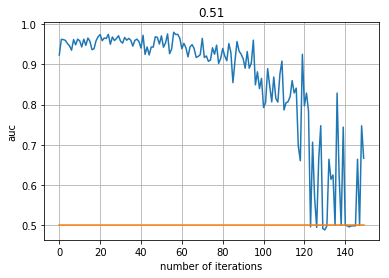

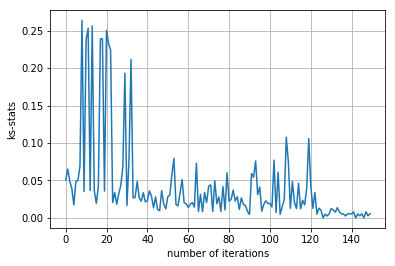

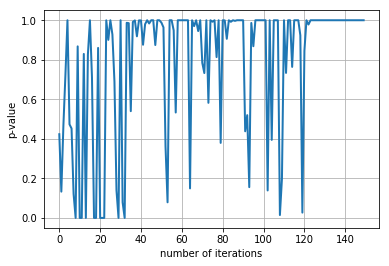

###################################


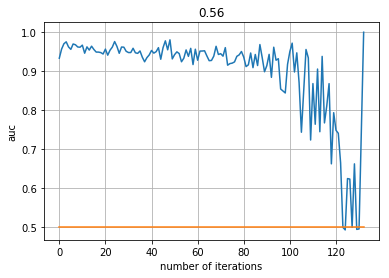

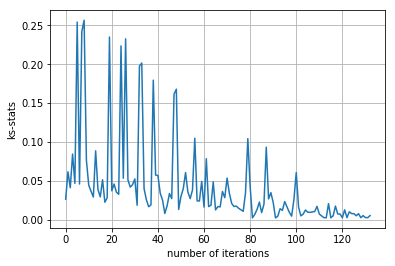

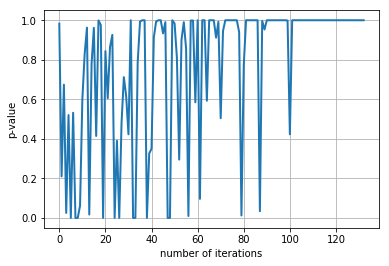

###################################


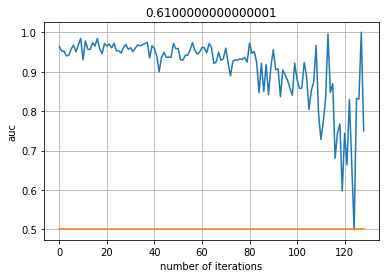

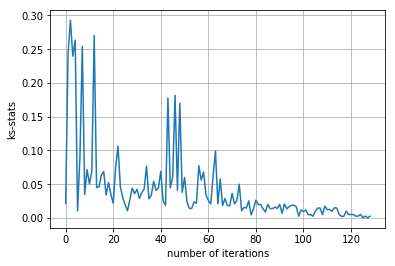

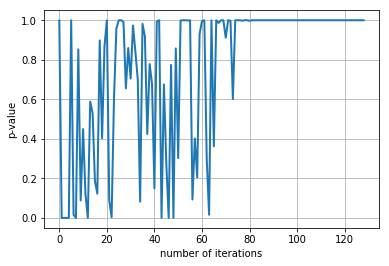

###################################


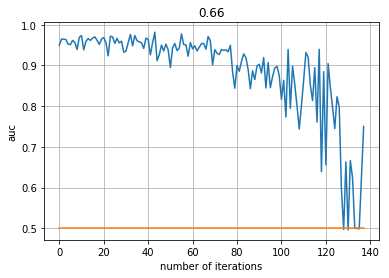

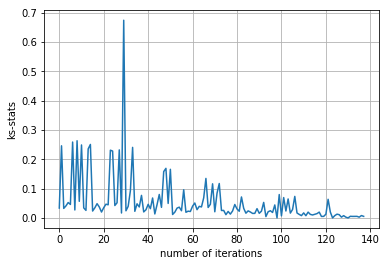

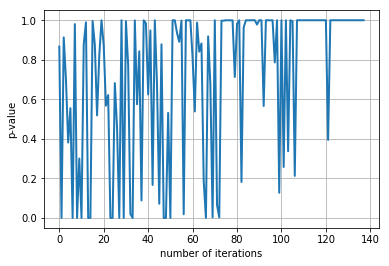

###################################


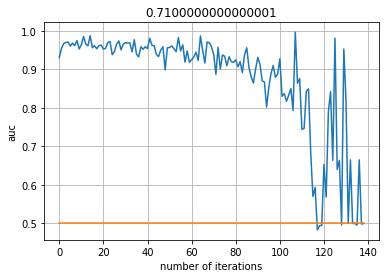

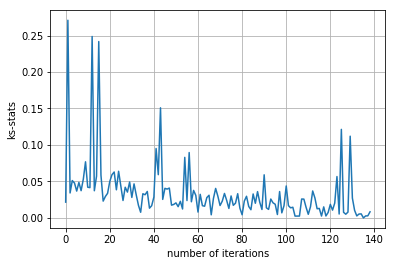

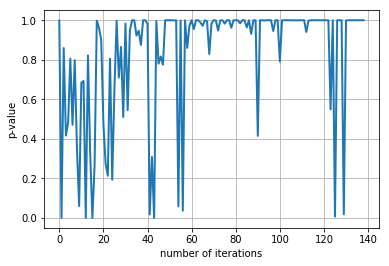

###################################


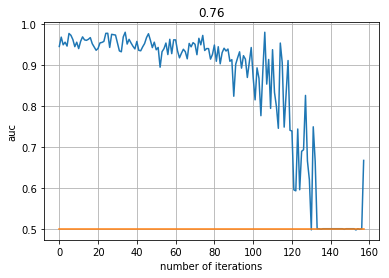

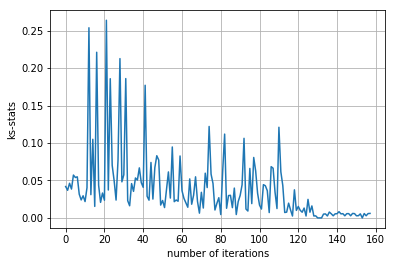

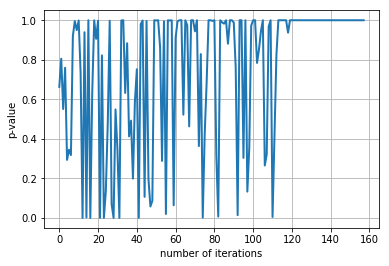

###################################


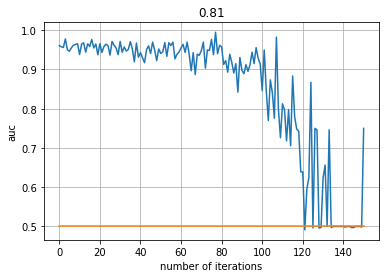

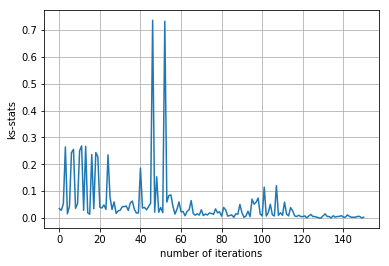

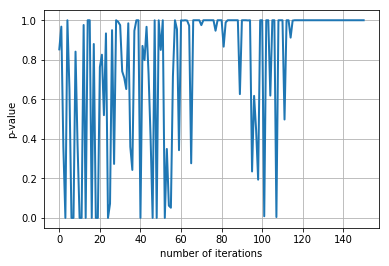

###################################


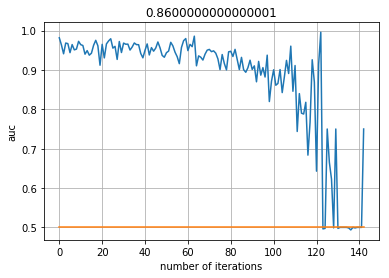

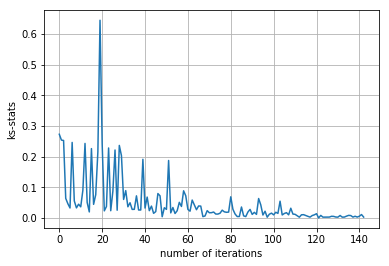

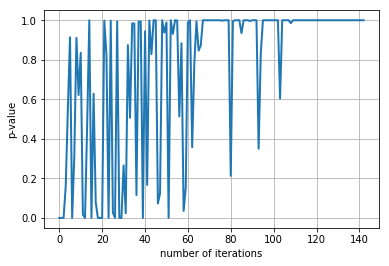

###################################


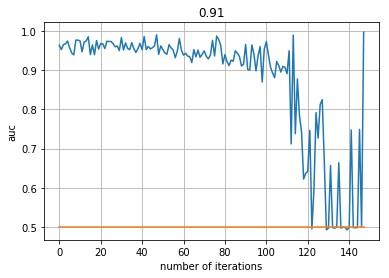

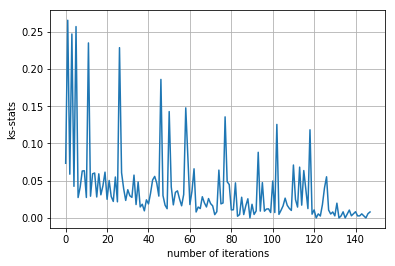

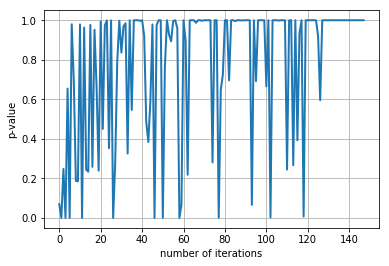

###################################


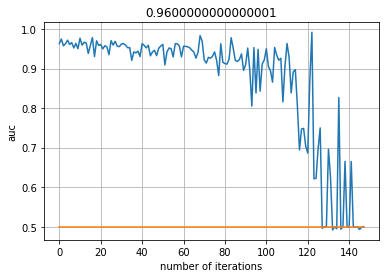

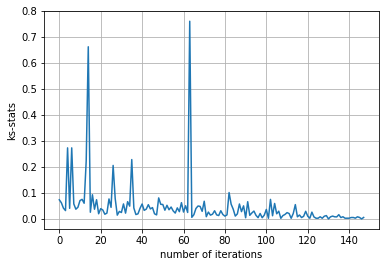

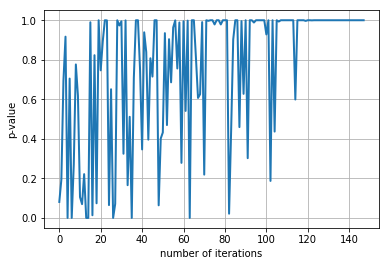

In [7]:
for t in np.arange(0, 1, 0.05):
    
    print('###################################')
    
    temperature = min(0.01 + t, 1) 
    max_drop = 5
    limit = 100

    score = []

    while (len(data[data.label == 1]) > max_drop and
           len(data[data.label == 0]) > max_drop and
           len(data.label) > limit):

        nonrep = data[data.label == 1].copy(deep=True)
        rep = data[data.label == 0].copy(deep=True)

        nonrep['bootstrap'] = bootstrap(len(nonrep.index))
        rep['bootstrap'] = bootstrap(len(rep.index))

        data = pd.concat([nonrep, rep], sort=True)

        train = data[data.bootstrap == 1].copy(deep=True)
        test = data[data.bootstrap == 0].copy(deep=True)

        dt = DecisionTreeClassifier(max_depth=6)

        dt.fit(train[cols], train.label)
        preds = [p[1] for p in dt.predict_proba(test[cols])] # might be 0 or 1 here.

        #print(dt.feature_importances_)
        score.append((test.label, preds))

        test['removed'] = remove(preds, max_drop, temperature)
        test = test[test.removed == 0]
        test.drop('removed', axis=1)

        data = pd.concat([train, test], sort=True)

        #print(len(data.index), end=', ')
    data = data_base.copy(deep=True)

    plots(score, temperature)